In [1]:
import sys
import pandas as pd

sys.path.append('/opt/hydra/')

import library.analysis as hydra

In [2]:
exp_path = '../data/TH-ALVEOLAR-log2TPM1.tsv'
mm_path = '../data/hydra-alveolar/MultiModalGenes'

In [3]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [4]:
exp.shape

(16619, 44)

In [6]:
help(hydra.ScanEnrichmentAnalysis)

Help on class ScanEnrichmentAnalysis in module library.analysis:

class ScanEnrichmentAnalysis(__builtin__.object)
 |  Methods defined here:
 |  
 |  __init__(self, mm_path, exp_path, gmt_path, min_prob_range=None, min_effect_filter=1.0, **kwargs)
 |      Class to explore the function of multimodally expressed genes.
 |      
 |      :param min_prob_range (iterable): Iterable containing floats between 0 and 0.5
 |  
 |  plot(self)
 |  
 |  scan(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [ ]:
scan = hydra.ScanEnrichmentAnalysis(mm_path, 
                                    exp_path, 
                                    'GO',
                                     min_prob_range=[0.1, 0.2, 0.3]).scan()

In [12]:
import numpy as np

sweep_terms = {}
sweep_genes = {}
for x in np.linspace(0.3, 0.45, 6):

    try:
        mm = hydra.EnrichmentAnalysis(mm_path,
                                      exp_path,
                                      min_prob_filter=x,
                                      gmt_path='GO')
    
        print 'Min Prob: ', x
        print 'Num Genes: ', len(mm.get_enriched_term_genes())
        print mm.get_enriched_terms()
        print
    
        sweep_terms[x] = mm.get_enriched_terms()
        sweep_genes[x] = mm.get_enriched_term_genes()
        
    except ValueError:
        continue

Min Prob:  0.3
Num Genes:  19
   Unnamed: 0          ID                               Description GeneRatio  \
0  GO:0006958  GO:0006958  complement activation, classical pathway    19/113   
1  GO:0099024  GO:0099024              plasma membrane invagination     6/113   

    BgRatio        pvalue      p.adjust        qvalue  \
0  74/11952  9.955507e-23  1.834800e-19  1.596025e-19   
1  65/11952  3.279411e-05  1.285948e-03  1.118599e-03   

                                              geneID  Count  
0  IGHV3-15/IGKV3-15/IGHG4/IGKV1-5/IGLV3-21/IGLV3...     19  
1  IGHV3-15/IGHG4/IGHV1-69-2/IGHV3-23/IGLL5/IGHV4-61      6  

Min Prob:  0.33
Num Genes:  31
   Unnamed: 0          ID                                    Description  \
0  GO:0030900  GO:0030900                          forebrain development   
1  GO:0060415  GO:0060415                    muscle tissue morphogenesis   
2  GO:0048644  GO:0048644                     muscle organ morphogenesis   
3  GO:0006958  GO:0006958       

ValueError: No enriched terms found.

In [13]:
sweep_genes[0.33]

['SLC6A3',
 'MYF5',
 'MYF6',
 'IGHV3-15',
 'IGLV2-11',
 'IGHV3-33',
 'MYL3',
 'ADCYAP1',
 'TRDN',
 'KCNC2',
 'NR0B1',
 'RYR2',
 'FAM155A',
 'TH',
 'IGHV4-59',
 'EFNA2',
 'PAX5',
 'PAX7',
 'IGKV2-30',
 'SALL3',
 'IGHV3-23',
 'IGF2BP1',
 'XIRP2',
 'MYH7',
 'NEUROD1',
 'DMRTA2',
 'CCL19',
 'IGHV4-61',
 'CXCL9',
 'ITGAL',
 'OTP']

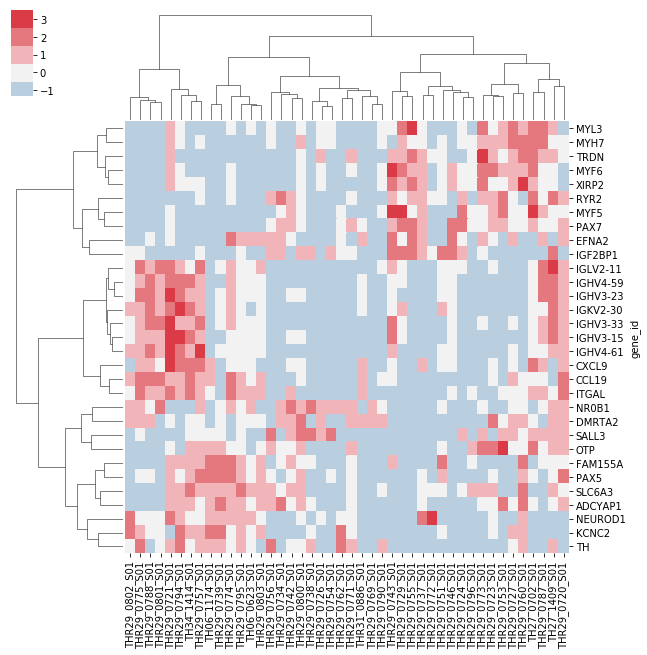

In [14]:
hclust = hydra.HClust(exp.reindex(sweep_genes[0.33]))
hclust.plot()

In [16]:
sweep_assign = {}
sweep_cluster_gsea = {}
for key, genes in sweep_genes.items():
    clus = hydra.MultivariateMixtureModel(data=exp.reindex(genes),
                                          center=True,
                                          gamma=5.0,
                                          variance=2.0,
                                          K=1)
    
    print 'Min Prob: ', key
    print 'Num Genes: ', len(genes) 
    print len(clus.hmodel.allocModel.get_active_comp_probs())
    sweep_assign[key] = clus.get_assignments(exp.reindex(genes))
    
    if len(clus.hmodel.allocModel.get_active_comp_probs()) < 2:
        continue
    
    sweep_cluster_gsea[key] = clus.get_cluster_features(exp,
                                                        gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
DELETE @ lap 2.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 3.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 4.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 5.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 6.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 7.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 8.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 9.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 10.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 11.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 12.00: Ineligible. Did not find >= 2 UIDs in entire model.
DELETE @ lap 13.00: Ineligible. Did not find >= 2 UIDs in entire model.
Min Prob:  0.36
Num 

In [18]:
sweep_cluster_gsea[0.33][0].head()

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
KERATINIZATION%GOBP%GO:0031424,0.000311,0.016010,0.585541,3.010259,0,24,CDH3|PKP1|PCSK6|KRT17|KRT8|CELA2A|FURIN|KRT31|...
CORNIFICATION%GOBP%GO:0070268,0.000303,0.015706,0.563362,2.851128,0,23,PKP1|PCSK6|KRT17|KRT8|CELA2A|FURIN|KRT31|KRT80...
KERATINIZATION%REACTOME DATABASE ID RELEASE 66%6805567,0.000303,0.015706,0.563362,2.851128,0,23,PKP1|PCSK6|KRT17|KRT8|CELA2A|FURIN|KRT31|KRT80...
HALLMARK_HYPOXIA%MSIGDB_C2%HALLMARK_HYPOXIA,0.002183,0.053073,0.307738,2.795547,0,181,ERRFI1|PNRC1|PKP1|ATF3|GBE1|EDN2|GRHPR|JUN|DUS...
ALANINE AND ASPARTATE METABOLISM%WIKIPATHWAYS_20181110%WP106%HOMO SAPIENS,0.000225,0.012855,0.751657,2.792113,0,11,AGXT|ASS1|ABAT|GAD1|GOT2|GOT1|DARS|ASPA


In [19]:
sweep_cluster_gsea[0.33][1].head()

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
HALLMARK_ALLOGRAFT_REJECTION%MSIGDB_C2%HALLMARK_ALLOGRAFT_REJECTION,0.000291,0.012210,0.619569,4.775193,0,148,CD79A|CD3D|CD3E|LCK|CCL19|CD2|LTB|CD8A|IL2RG|I...
ADAPTIVE IMMUNE RESPONSE%GOBP%GO:0002250,0.000242,0.012081,0.715266,4.758336,0,79,IGHV4-61|IGKV4-1|IGKV2-28|IGHG4|IGHV3-15|IGHG2...
ADAPTIVE IMMUNE RESPONSE BASED ON SOMATIC RECOMBINATION OF IMMUNE RECEPTORS BUILT FROM IMMUNOGLOBULIN SUPERFAMILY DOMAINS%GOBP%GO:0002460,0.000230,0.012081,0.726118,4.645233,0,67,IGHV4-61|IGKV4-1|IGKV2-28|IGHG4|IGHV3-15|IGHG2...
IMMUNOREGULATORY INTERACTIONS BETWEEN A LYMPHOID AND A NON-LYMPHOID CELL%REACTOME DATABASE ID RELEASE 66%198933,0.000233,0.012081,0.715239,4.582782,0,68,IGKV4-1|IGKV2-28|IGKV3-11|IGKV2D-28|SLAMF7|CD3...
LYMPHOCYTE MEDIATED IMMUNITY%GOBP%GO:0002449,0.000231,0.012081,0.734975,4.576309,0,62,IGHV4-61|IGKV4-1|IGKV2-28|IGHG4|IGHV3-15|IGHG2...


In [20]:
sweep_cluster_gsea[0.33][2].head()

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
RNA SPLICING%GOBP%GO:0008380,0.000067,0.010738,0.411996,2.605390,0,295,LSM1|POLR2K|SNRPB2|PHF5A|PABPC1|TGS1|CLNS1A|SR...
"RNA SPLICING, VIA TRANSESTERIFICATION REACTIONS%GOBP%GO:0000375",0.000067,0.010738,0.414409,2.604867,0,273,LSM1|POLR2K|SNRPB2|PHF5A|PABPC1|TGS1|CLNS1A|SR...
"RNA SPLICING, VIA TRANSESTERIFICATION REACTIONS WITH BULGED ADENOSINE AS NUCLEOPHILE%GOBP%GO:0000377",0.000067,0.010738,0.410982,2.580786,0,270,POLR2K|SNRPB2|PHF5A|PABPC1|TGS1|CLNS1A|SRSF8|C...
"MRNA SPLICING, VIA SPLICEOSOME%GOBP%GO:0000398",0.000067,0.010738,0.410982,2.580786,0,270,POLR2K|SNRPB2|PHF5A|PABPC1|TGS1|CLNS1A|SRSF8|C...
MRNA PROCESSING%GOBP%GO:0006397,0.000067,0.010738,0.400873,2.554569,0,325,POLR2K|SNRPB2|PHF5A|PABPC1|TGS1|CLNS1A|THOC5|S...
